In [1]:
import train as tn
reload(tn)

import plotting
reload(plotting)

import matplotlib.pyplot as plt
#plt.style.use('seaborn-ticks')
plt.style.use('seaborn-poster')
%matplotlib inline
#%matplotlib notebook

import numpy as np

Welcome to JupyROOT 6.07/07


In [2]:
inputDir="/eos/user/m/musella/data/mod_dep_005"
fname = inputDir+"/output_InsideAcceptance_125.root"
pfx = "genDiphotonDumper/trees/InsideAcceptance_125_13TeV"
load = True

ncats = 3
genBranches = ["genPt","genRapidity",
            "genJet2p5Pt0","genJet2p5Rapidity0",
            "genJet2p5Pt1","genJet2p5Rapidity1",
            "genJet2p5Pt2","genJet2p5Rapidity2",
            "genJet2p5Pt3","genJet2p5Rapidity3",
            "weight",
            "genNjets2p5"
           ]
recoBranches = ['recoPt','recoRapidity',"recoNjets2p5"]


def loadOrMake(name):
    
    global load
    make = False
    if load:
        onDisk = tn.IO.load(name)
        if onDisk.genBranches != genBranches or onDisk.recoBranches != recoBranches:
            make = True
        if onDisk.ncats != ncats:
            make = True
            load = False
    else:
        make = True
    
    if make:
        if not load:
            made = tn.EfficiencyFitter(name)
        else:
            made = onDisk
        
        made.readData(ncats,genBranches,recoBranches,[(fname,None,pfx)])
        if not 'absGenRapidity' in made.df.columns:
            made.df['absGenRapidity'] = np.abs(made.df['genRapidity'])
        made.defineBins('recoPt',boundaries=[0,15,30,60,120,180,200])
        made.defineBins('recoNjets2p5',boundaries=[0,1,2,3,4])
        
    else:
        made = onDisk
        
    return made

effFitter = loadOrMake('effFitter')

In [3]:
effFitter.clfs.keys()

['recoPt', 'class']

In [4]:
if not 'class' in effFitter.clfs:
    effFitter.fitClass(trainevts=100000,
                       max_depth=5,learning_rate=0.2,n_estimators=100,min_weight_fraction_leaf=1e-3)
    
if not 'recoPt' in effFitter.clfs:
    effFitter.split = None
    effFitter.fitBins('recoPt',['genPt','absGenRapidity'],
                      trainevts=100000,max_depth=7,learning_rate=0.1,n_estimators=500,min_weight_fraction_leaf=1e-4)

In [6]:
## to_delete = filter(lambda x: "_prob_" in x, effFitter.df.columns)
## for col in to_delete: del effFitter.df[col]
## map(effFitter.runPrediction, ['class','recoPt'])

## clf_keys = effFitter.clfs.keys()
## clf_keys = filter(lambda x: x=='class', clf_keys)+filter(lambda x: x!='class', clf_keys)

clf_keys = ['class','recoPt']

for x in filter(lambda y: "CatCat" in y, effFitter.df.columns):
    del effFitter.df[x]

for key in clf_keys:
    catKey = '%sCat_prob_0' % key
    if not catKey in effFitter.df.columns: effFitter.runPrediction(key)


effFitter.df.columns

Index([u'absweight', u'class', u'genJet2p5Pt0', u'genJet2p5Pt1',
       u'genJet2p5Pt2', u'genJet2p5Pt3', u'genJet2p5Rapidity0',
       u'genJet2p5Rapidity1', u'genJet2p5Rapidity2', u'genJet2p5Rapidity3',
       u'genNjets2p5', u'genPt', u'genRapidity', u'recoNjets2p5', u'recoPt',
       u'recoRapidity', u'weight', u'absGenRapidity', u'recoPtBin',
       u'recoPtCat', u'recoNjets2p5Bin', u'recoNjets2p5Cat', u'class_prob_0',
       u'class_prob_1', u'class_prob_2', u'class_prob_3', u'recoPt_prob_0',
       u'recoPt_prob_1', u'recoPt_prob_2', u'recoPt_prob_3', u'recoPt_prob_4',
       u'recoPt_prob_5', u'recoPt_prob_6', u'recoPt_prob_7', u'recoPt_prob_8',
       u'recoPt_prob_9', u'recoPt_prob_10', u'recoPt_prob_11',
       u'recoPt_prob_12', u'recoPt_prob_13', u'recoPt_prob_14',
       u'recoPt_prob_15', u'recoPt_prob_16', u'recoPt_prob_17',
       u'recoPt_prob_18', u'recoPt_prob_19', u'recoPt_prob_20',
       u'recoPt_prob_21'],
      dtype='object')

In [7]:
tn.IO.save(effFitter)

In [ ]:
## from pandas.tools import plotting
## 
## group_by_class = effFitter.df.groupby('class')
## plotting.scatter_matrix(effFitter.df[['class_prob_0','class_prob_1','class_prob_2','class_prob_3']],figsize=(14,8))

In [8]:
class_grid,class_eff_map = effFitter.effMap('class',[(300,0,300),(300,0,3.)])
recoPt_grid,recoPt_eff_map = effFitter.effMap('recoPt',np.hstack([class_grid,class_eff_map]))

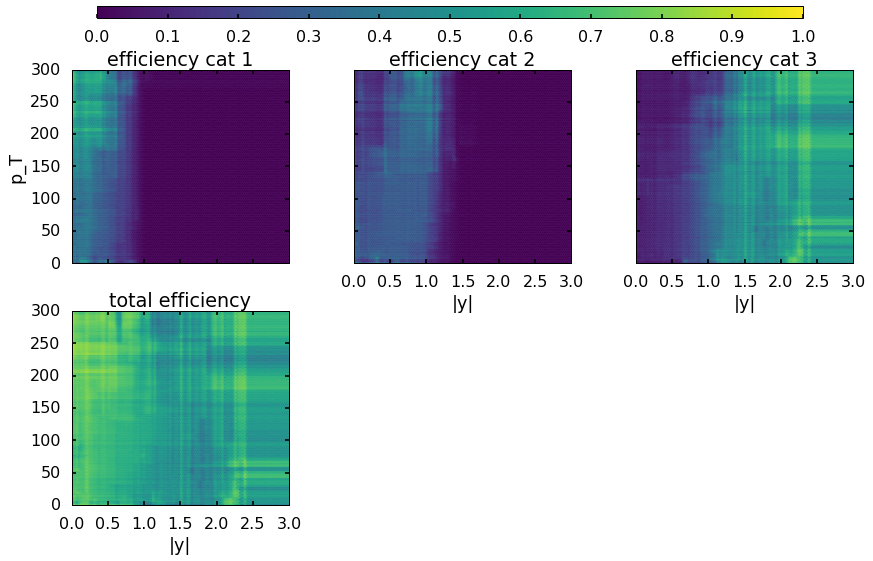

In [9]:
plotting.efficiency_map(class_grid[:,1],class_grid[:,0],class_eff_map,figsize=(14,8),xlabel="|y|",ylabel="p_T",
                        layout=(3,None))

plt.subplots_adjust(hspace = 0.25, wspace = 0.3, top=0.88)

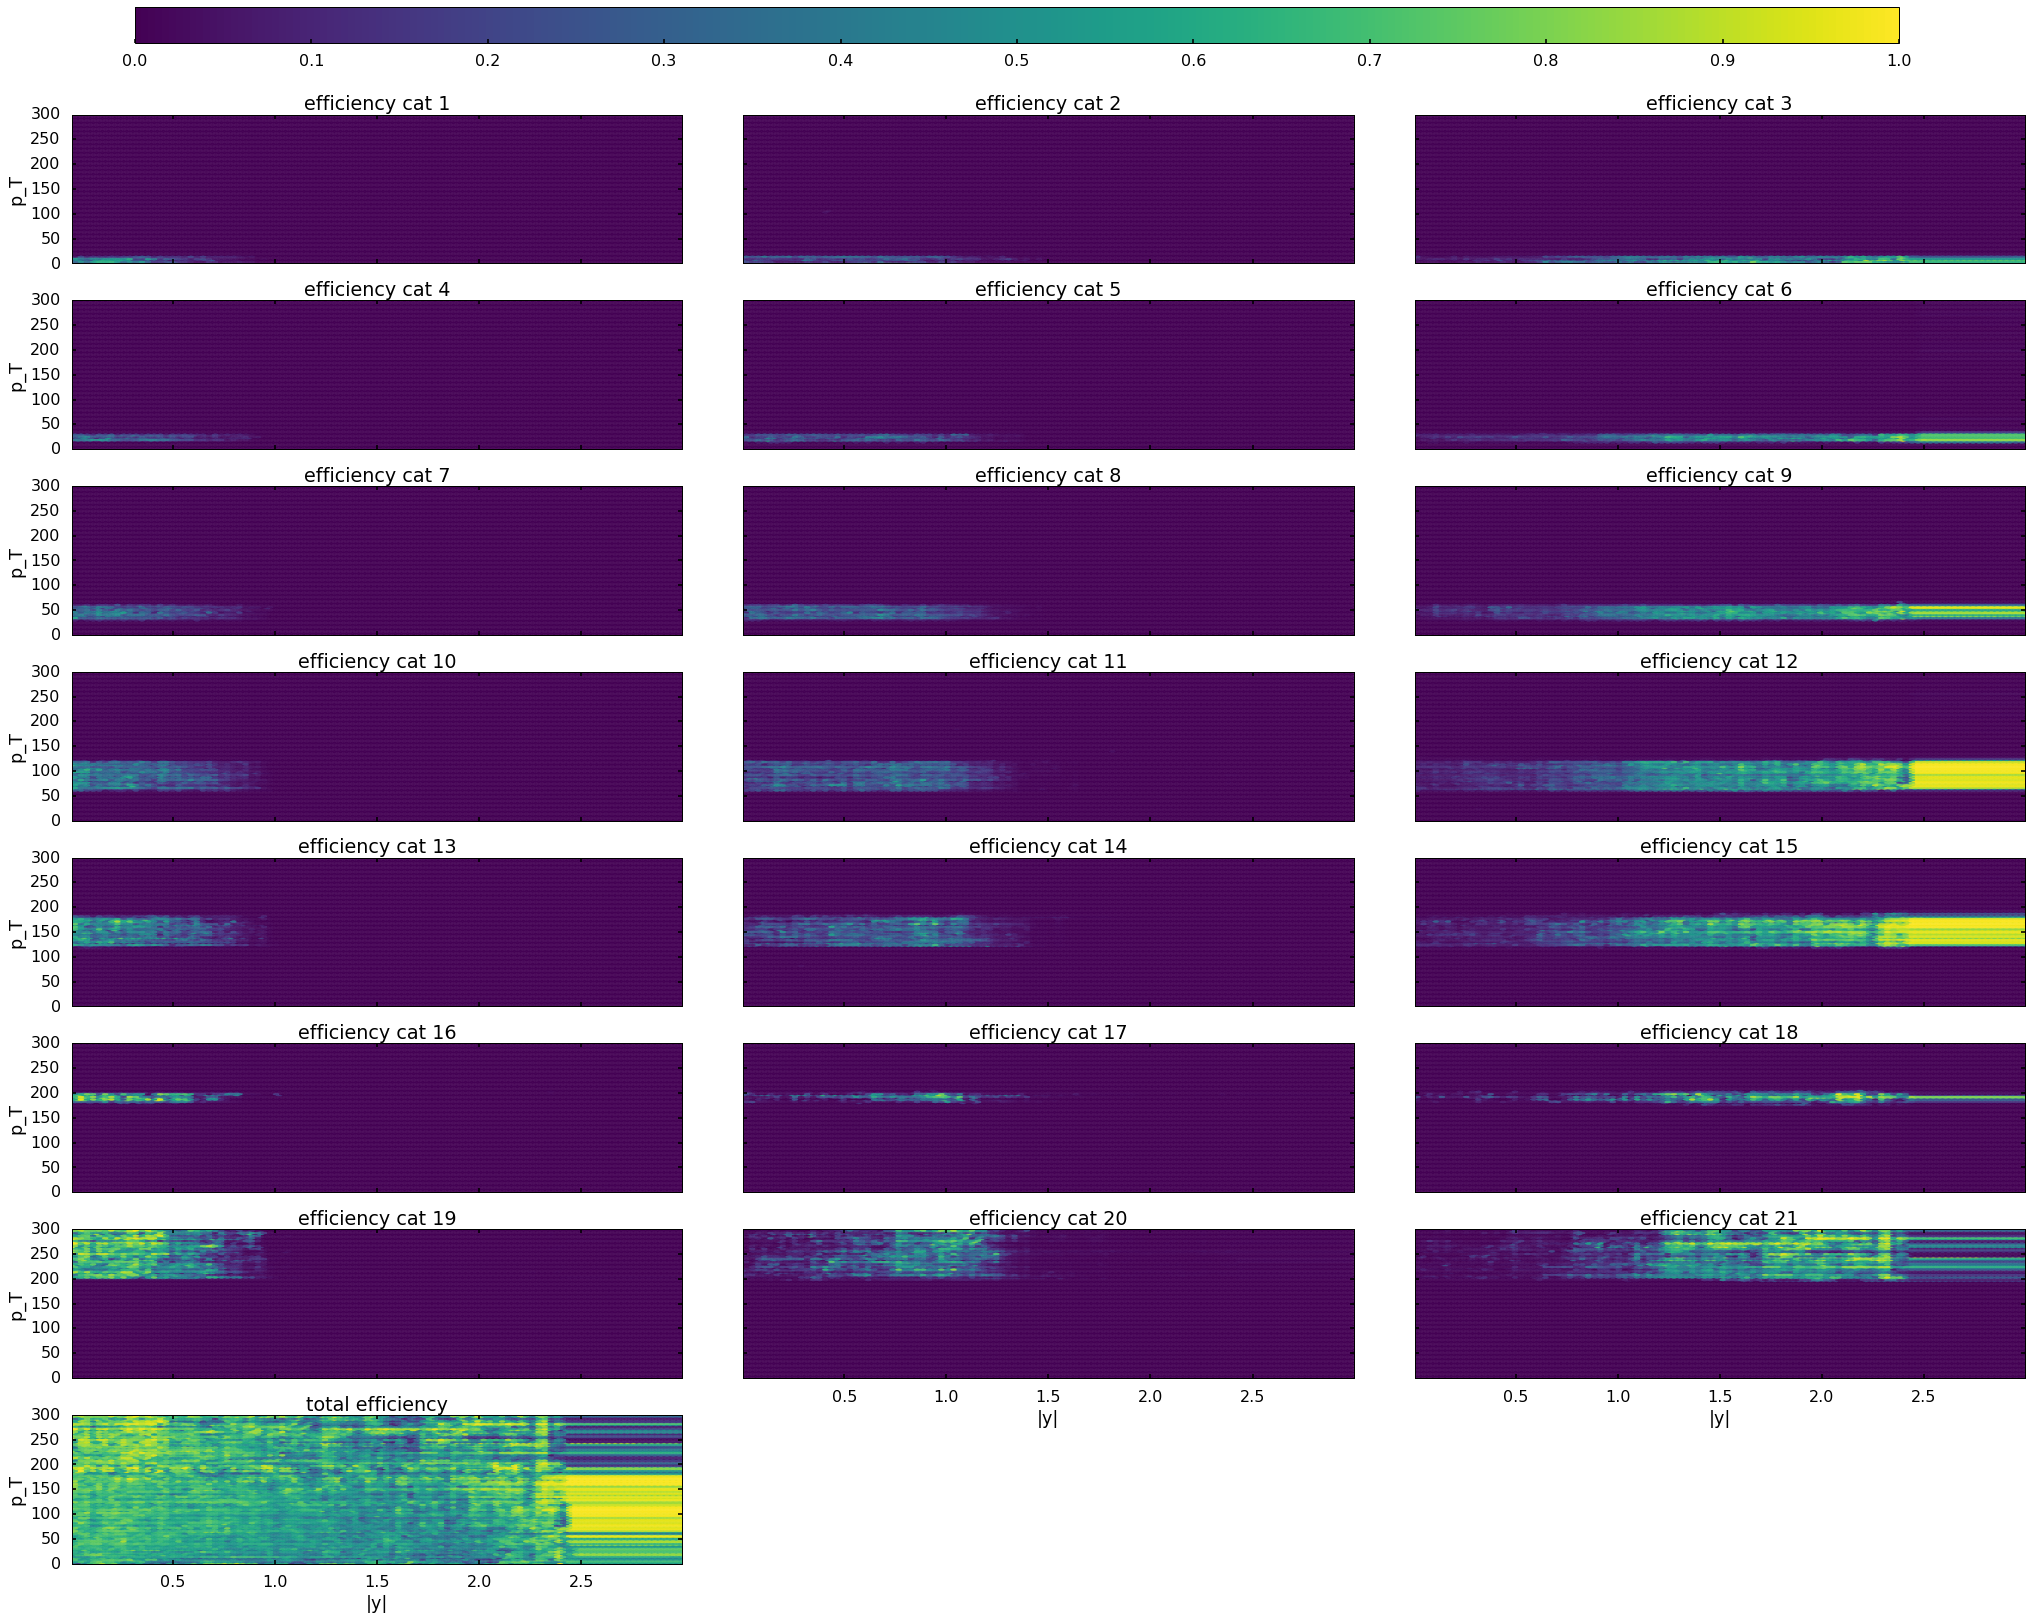

In [10]:
import plotting
reload(plotting)

plotting.efficiency_map(recoPt_grid[:,1],recoPt_grid[:,0],recoPt_eff_map,figsize=(35,25),xlabel="|y|",ylabel="p_T",
                       layout=(3,None))

plt.subplots_adjust(hspace = 0.25, wspace = 0.1, top=0.93)

In [11]:
resummed = np.array(map(lambda y: recoPt_eff_map[:,y].sum(), map(lambda x: range(x+1,22,3), range(3)) )).transpose()
classwise = class_eff_map[:,1:].sum(axis=0)

resummed / classwise

array([ 1.00550001,  0.92074435,  1.02103146])

In [12]:
resummed.sum() / classwise.sum()

1.0002119890346337

In [13]:
#group_by_class.plot(kind='hexbin',y='class_prob_0',x='class_prob_1',C='weight',table=True,layout=(2,2))
#group_by_class.plot(kind='hexbin',y='class_prob_1',x='class_prob_2',C='weight',layout=(2,2))
#,C='weight',subplots=False

In [14]:
#help(group_by_class)

In [15]:
effFitter.df.columns

Index([u'absweight', u'class', u'genJet2p5Pt0', u'genJet2p5Pt1',
       u'genJet2p5Pt2', u'genJet2p5Pt3', u'genJet2p5Rapidity0',
       u'genJet2p5Rapidity1', u'genJet2p5Rapidity2', u'genJet2p5Rapidity3',
       u'genNjets2p5', u'genPt', u'genRapidity', u'recoNjets2p5', u'recoPt',
       u'recoRapidity', u'weight', u'absGenRapidity', u'recoPtBin',
       u'recoPtCat', u'recoNjets2p5Bin', u'recoNjets2p5Cat', u'class_prob_0',
       u'class_prob_1', u'class_prob_2', u'class_prob_3', u'recoPt_prob_0',
       u'recoPt_prob_1', u'recoPt_prob_2', u'recoPt_prob_3', u'recoPt_prob_4',
       u'recoPt_prob_5', u'recoPt_prob_6', u'recoPt_prob_7', u'recoPt_prob_8',
       u'recoPt_prob_9', u'recoPt_prob_10', u'recoPt_prob_11',
       u'recoPt_prob_12', u'recoPt_prob_13', u'recoPt_prob_14',
       u'recoPt_prob_15', u'recoPt_prob_16', u'recoPt_prob_17',
       u'recoPt_prob_18', u'recoPt_prob_19', u'recoPt_prob_20',
       u'recoPt_prob_21'],
      dtype='object')

In [16]:
df = effFitter.df

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efd07113c90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7efd05608bd0>]], dtype=object)

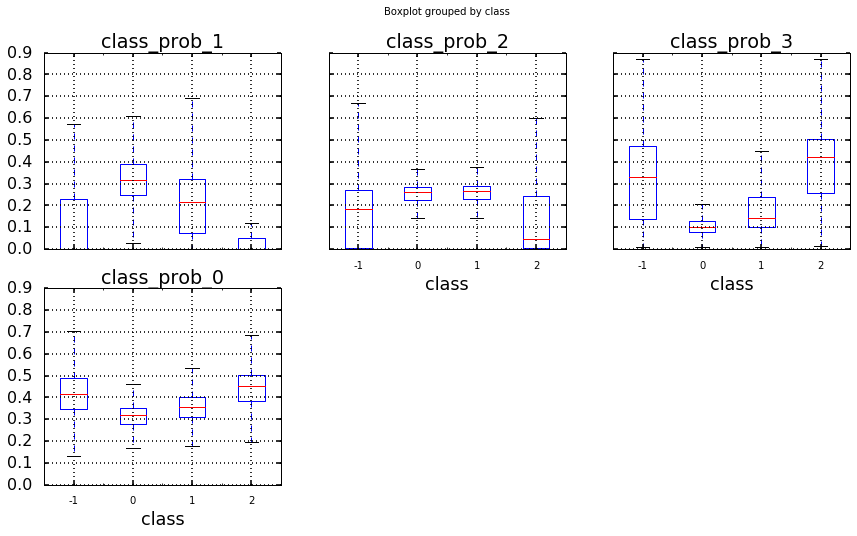

In [17]:
allcols = filter(lambda x: "class_prob_" in x and not "prob_0" in x, df.columns)+["class_prob_0"]

effFitter.df.boxplot(by='class',column=allcols,figsize=(14,8),layout=(2,3))

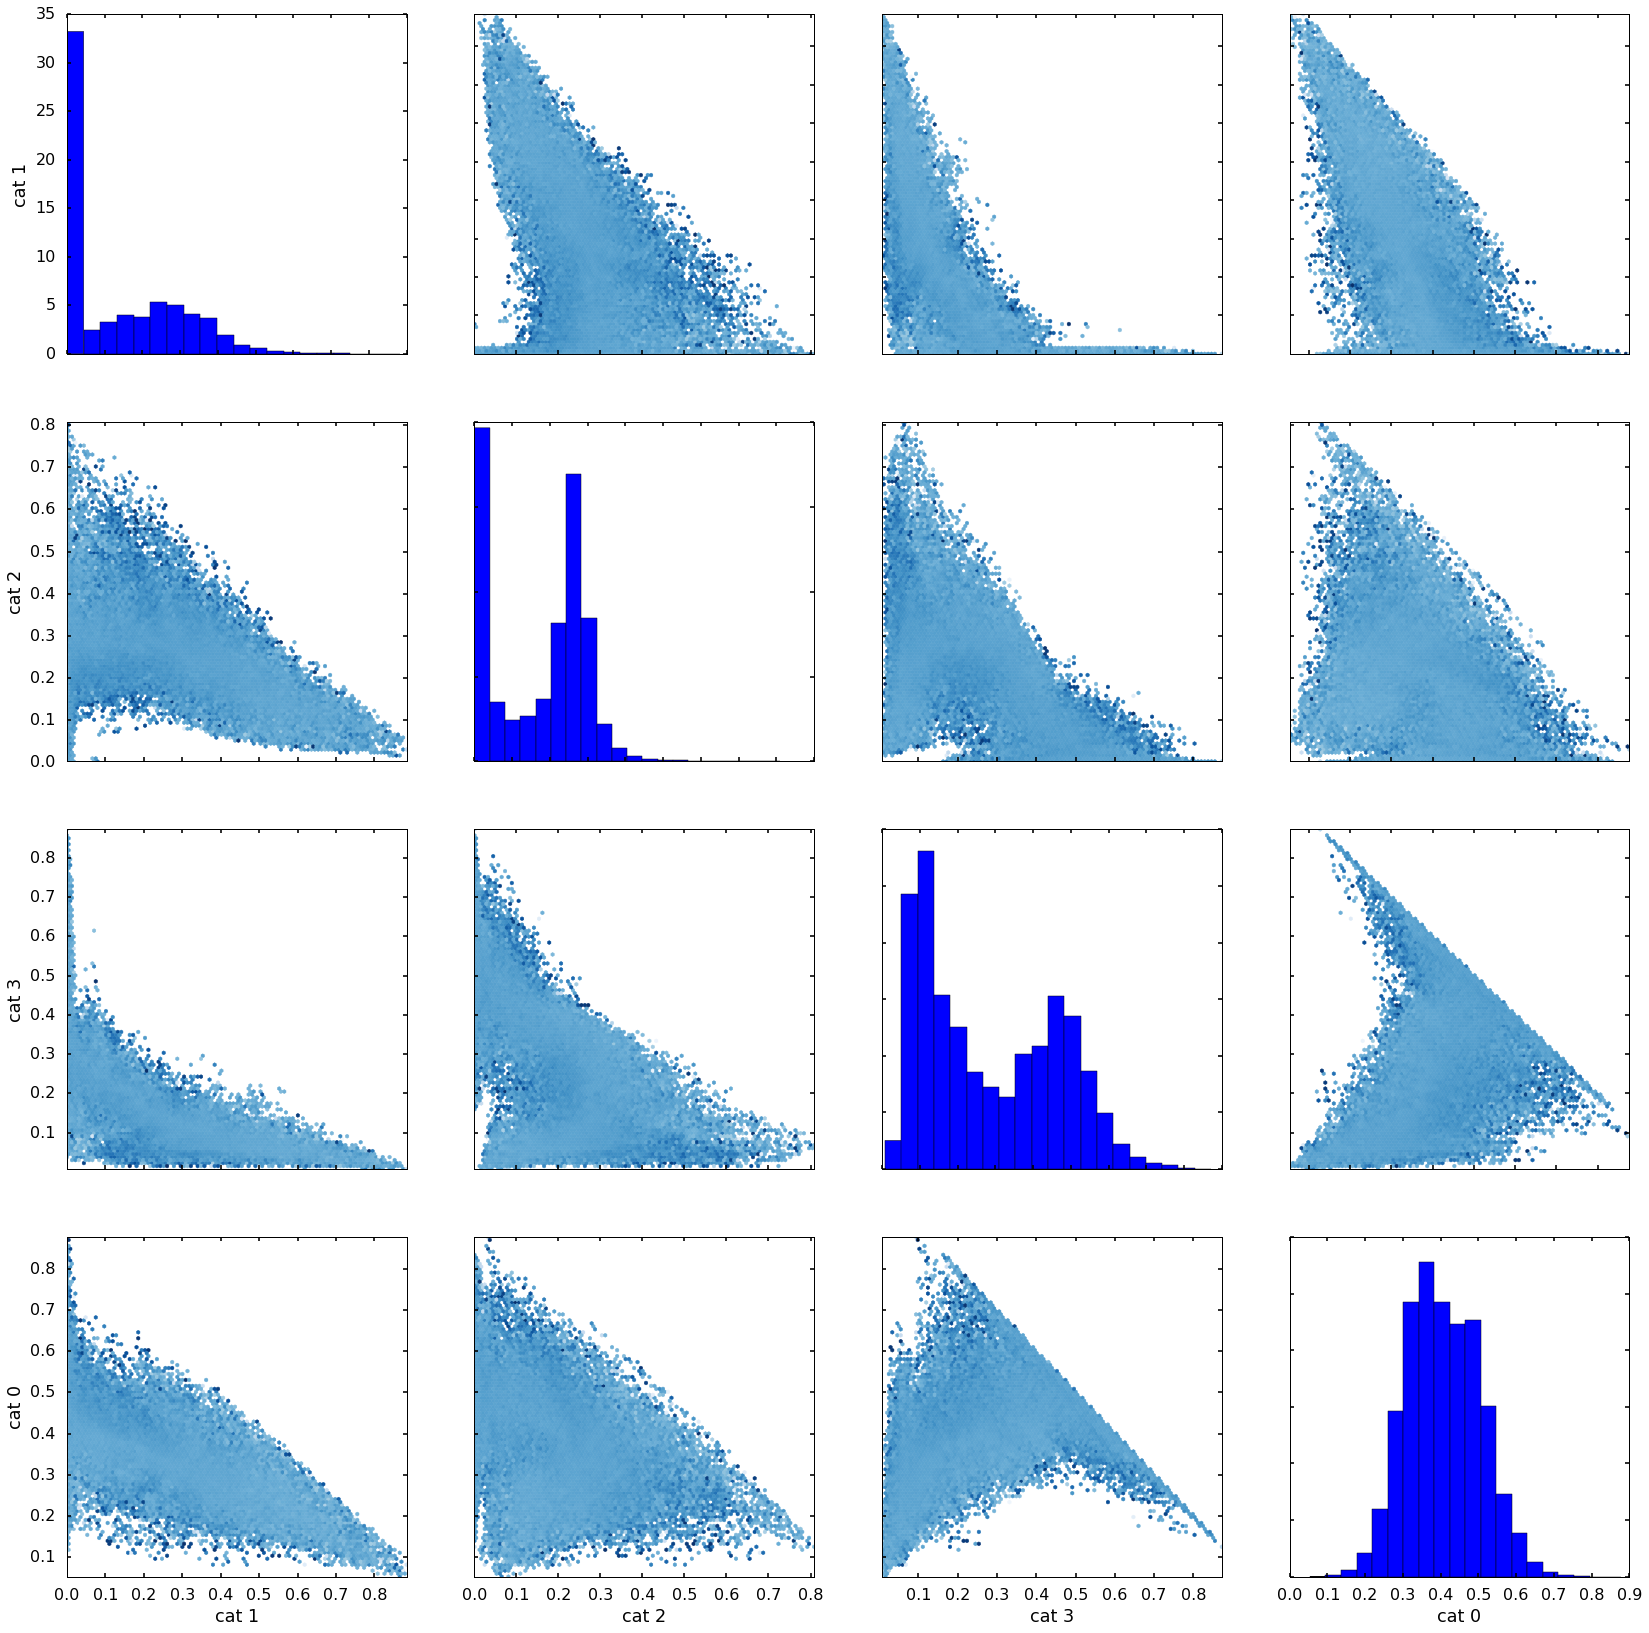

In [18]:
reload(plotting)
plotting.scatter_hist(df,allcols,figsize=(28,28))

In [20]:
(df['recoPt_prob_0']-df['class_prob_0']).describe()

count    1389404.000000
mean           0.030141
std            0.195443
min           -0.829578
25%           -0.104946
50%            0.025369
75%            0.158977
max            0.892621
dtype: float64

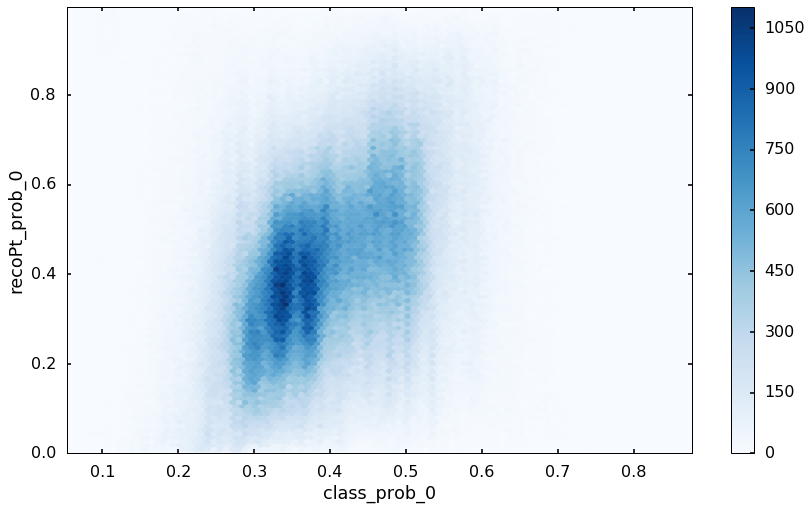

In [21]:
plt.figure(figsize=(14,8))
plt.hexbin(y=df['recoPt_prob_0'], x=df['class_prob_0'],cmap=plt.cm.Blues)
plt.ylabel('recoPt_prob_0')
plt.xlabel('class_prob_0')
plt.colorbar()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efd0763b2d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7efd0511cf10>]], dtype=object)

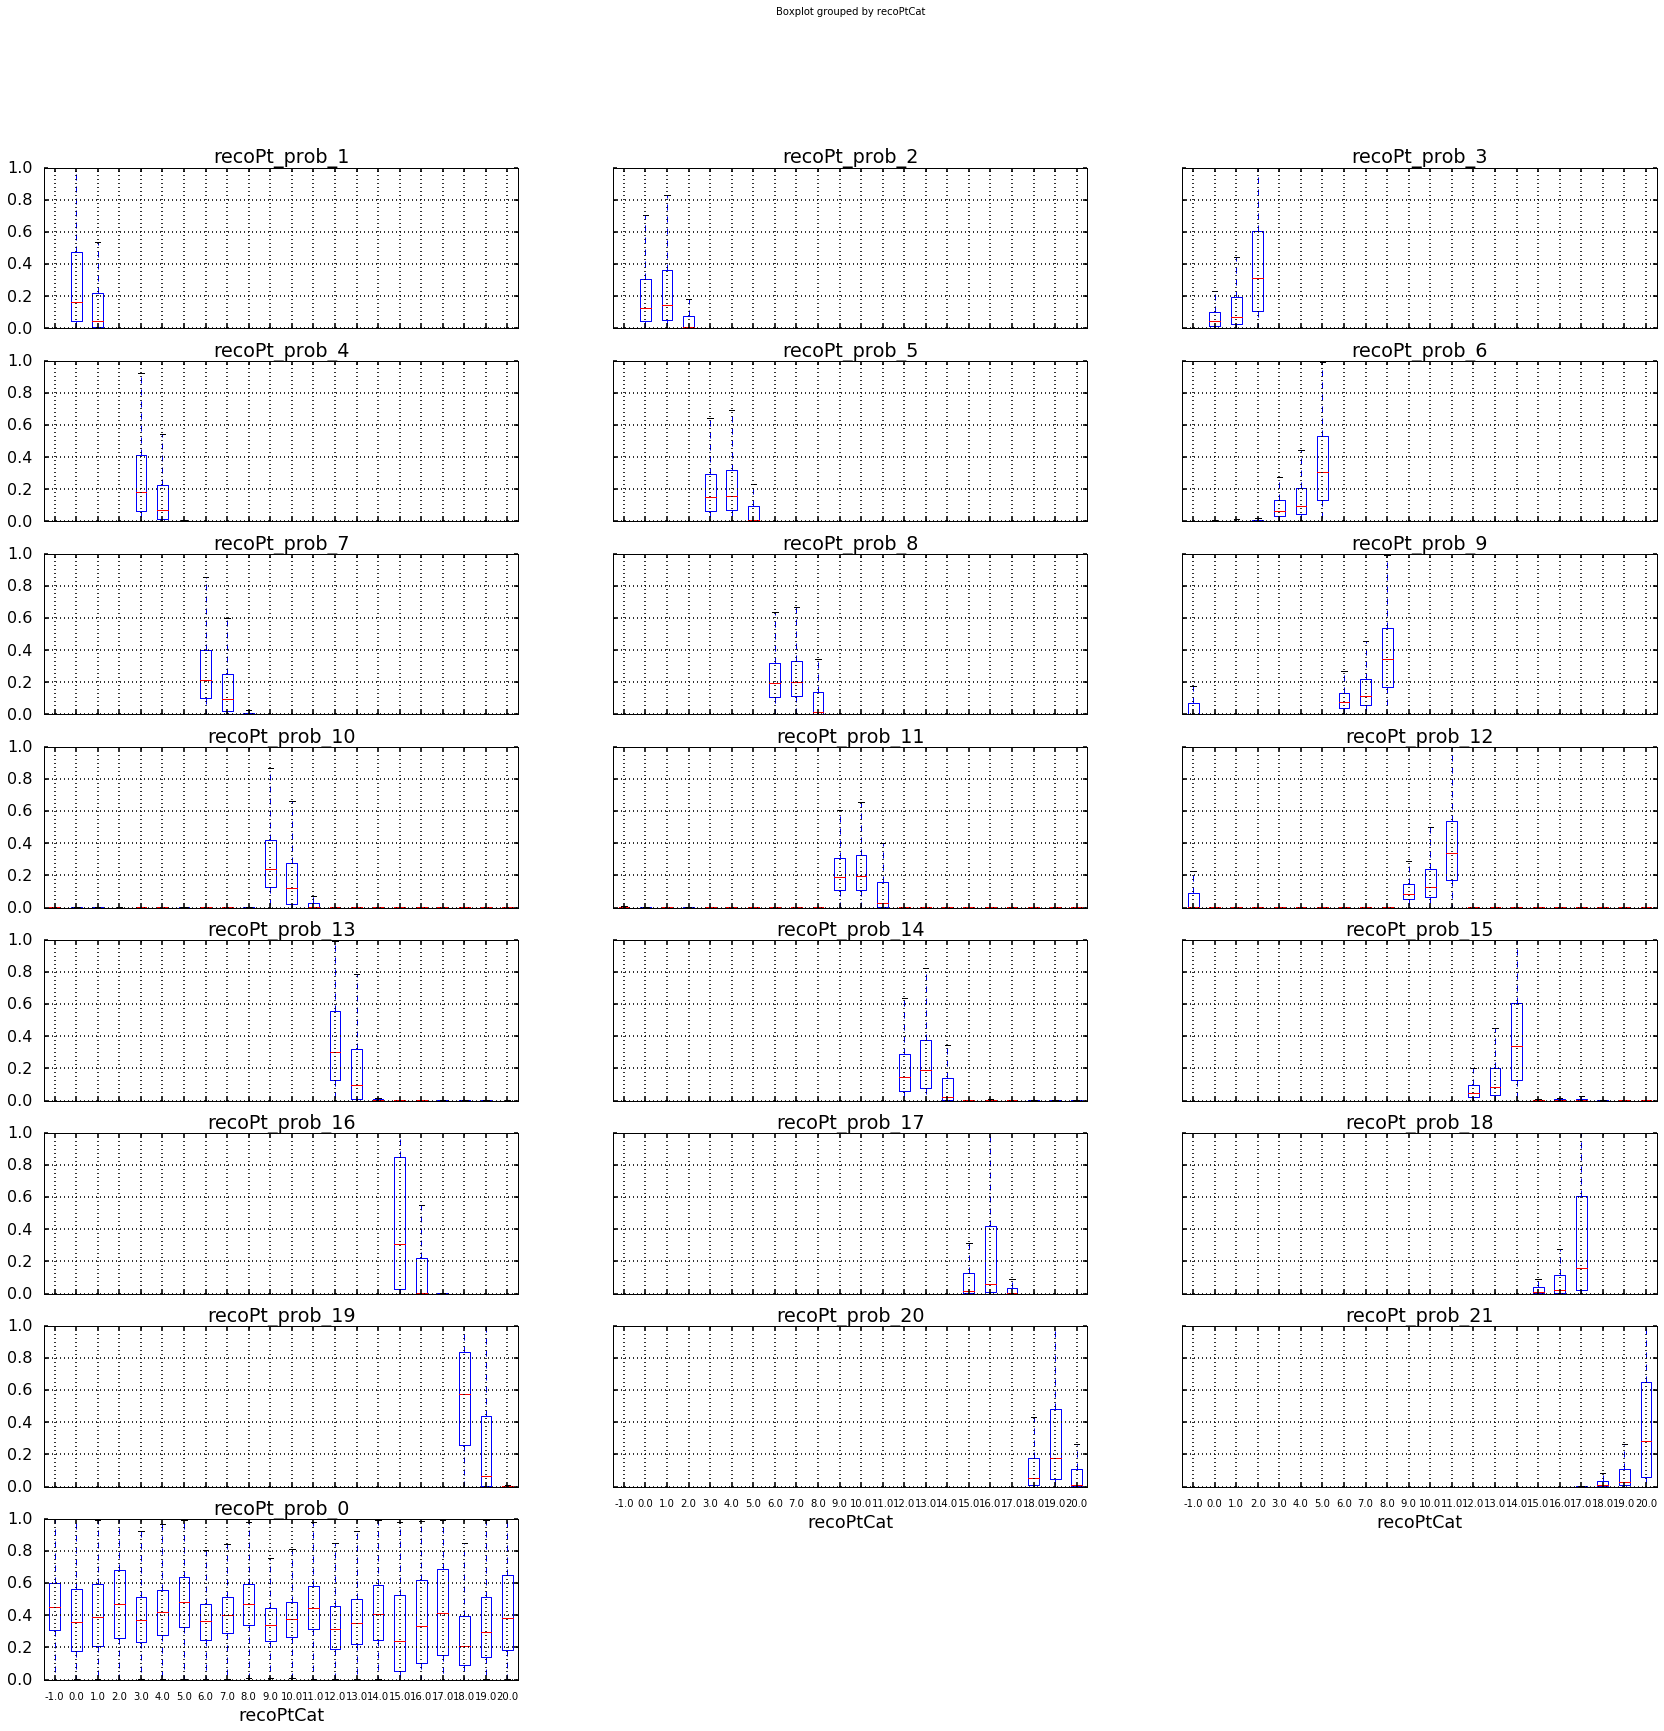

In [22]:
allcols = filter(lambda x: "recoPt_prob_" in x and not "prob_0" in x, df.columns)+['recoPt_prob_0']

effFitter.df.boxplot(by='recoPtCat',column=allcols,figsize=(28,28),layout=(8,3))

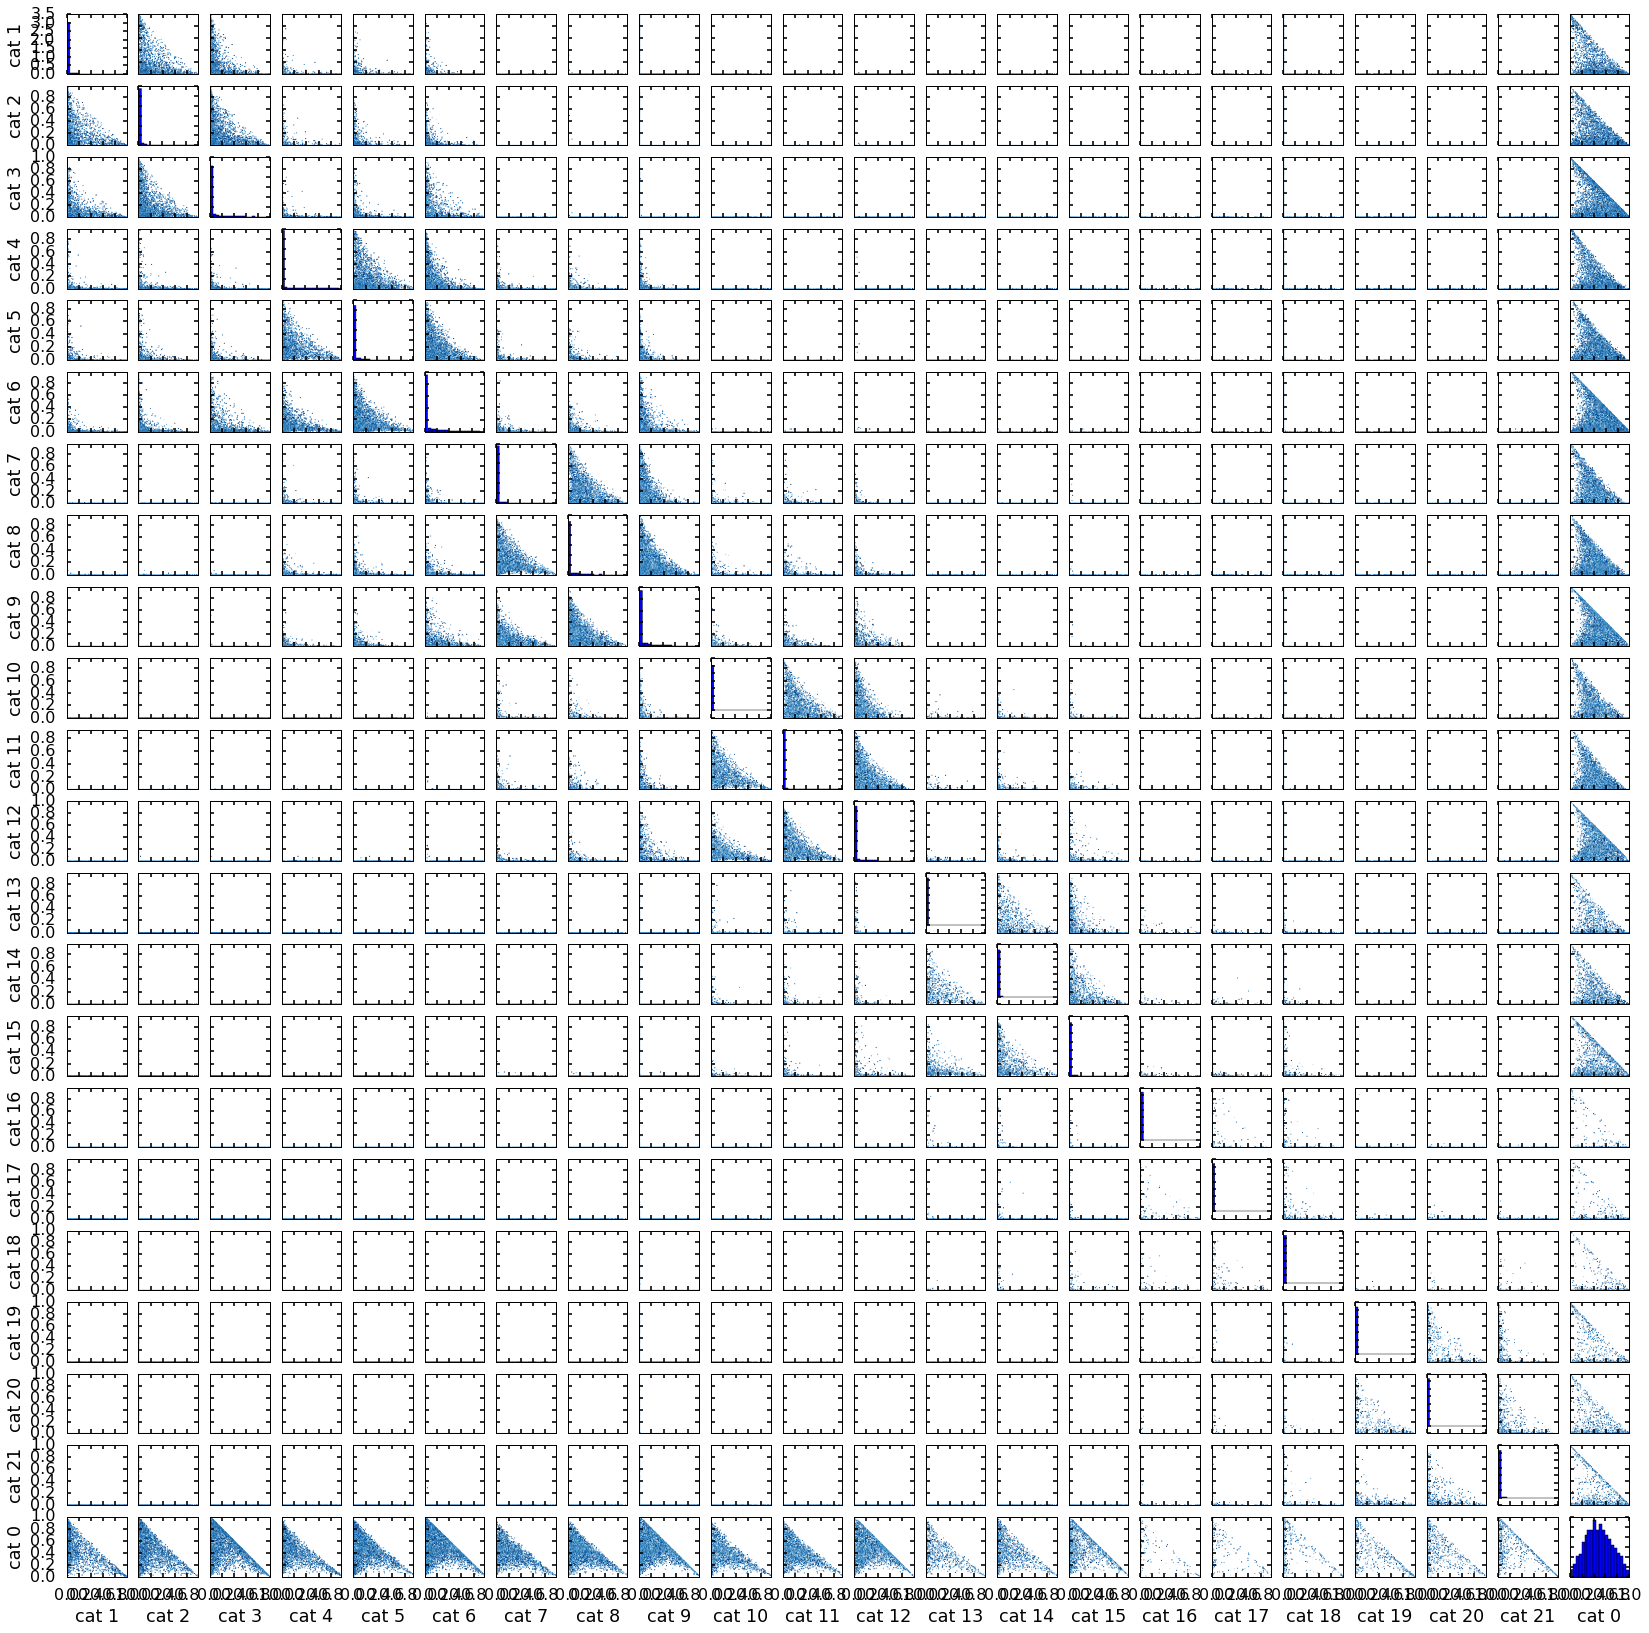

In [ ]:
plotting.scatter_hist(df[:30000],allcols,figsize=(28,28),log=True)

In [ ]:
#reload(tn)
#if not 'recoNjets2p5' in effFitter.clfs:
#effFitter.defineBins('recoNjets2p5',boundaries=[-0.5,1.5,2.5,3.5,4.5,5.5])
effFitter.split = None
effFitter.fitBins('recoNjets2p5',[
            'genJet2p5Pt0', 'genJet2p5Rapidity0',
            'genJet2p5Pt1', 'genJet2p5Rapidity1',
            'genJet2p5Pt2', 'genJet2p5Rapidity2',
            'genJet2p5Pt3', 'genJet2p5Rapidity3',
            'genPt','absGenRapidity'
            ],#factorized=True,
            trainevts=100000,max_depth=5,learning_rate=0.2,n_estimators=500,min_weight_fraction_leaf=1e-4)
    

In [26]:
effFitter.clfs
## from pandas.tools import plotting
## 
## group_by_class = df.groupby('recoPtCat')
## recoPtCatProbs = filter(lambda x: 'recoPtCat_prob' in x, df.columns)
## plotting.scatter_matrix(df[recoPtCatProbs],figsize=(28,16))

{'class': GradientBoostingClassifier(init=None, learning_rate=0.2, loss='deviance',
               max_depth=5, max_features=None, max_leaf_nodes=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.001, n_estimators=100,
               presort='auto', random_state=None, subsample=1.0, verbose=1,
               warm_start=False),
 'recoNjets2p5': GradientBoostingClassifier(init=None, learning_rate=0.2, loss='deviance',
               max_depth=5, max_features=None, max_leaf_nodes=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0001, n_estimators=500,
               presort='auto', random_state=None, subsample=1.0, verbose=1,
               warm_start=False),
 'recoPt': GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
               max_depth=7, max_features=None, max_leaf_nodes=None,
               min_samples_leaf=1, min_samples_split=2,
               mi

In [ ]:
#effFitter.name = 'effFitter_test'
tn.IO.save(effFitter)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efd07827d90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7efcc304d250>]], dtype=object)

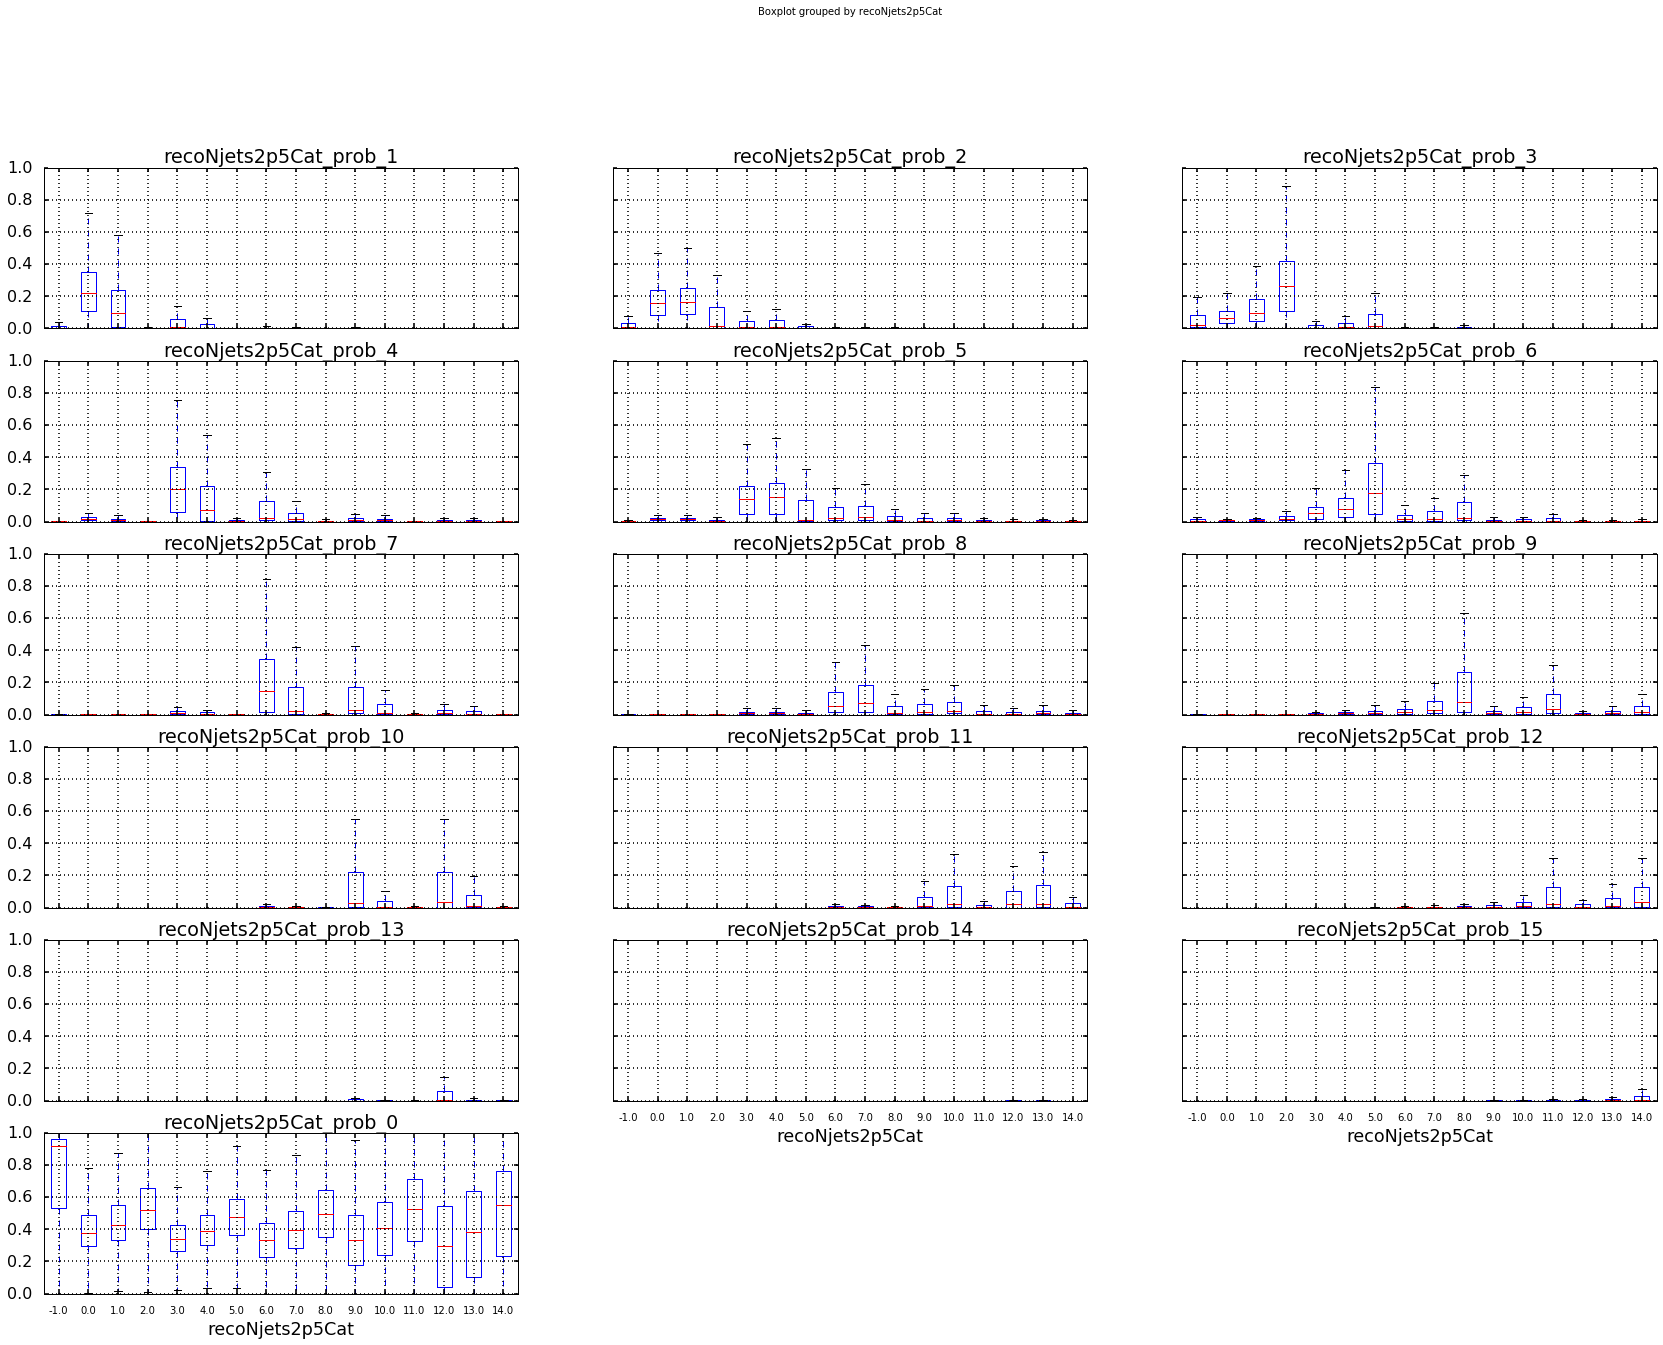

In [27]:
allcols = filter(lambda x: "recoNjets2p5Cat_prob_" in x and not "prob_0" in x, df.columns)+['recoNjets2p5Cat_prob_0']

effFitter.df.boxplot(by='recoNjets2p5Cat',column=allcols,figsize=(28,28),layout=(8,3))

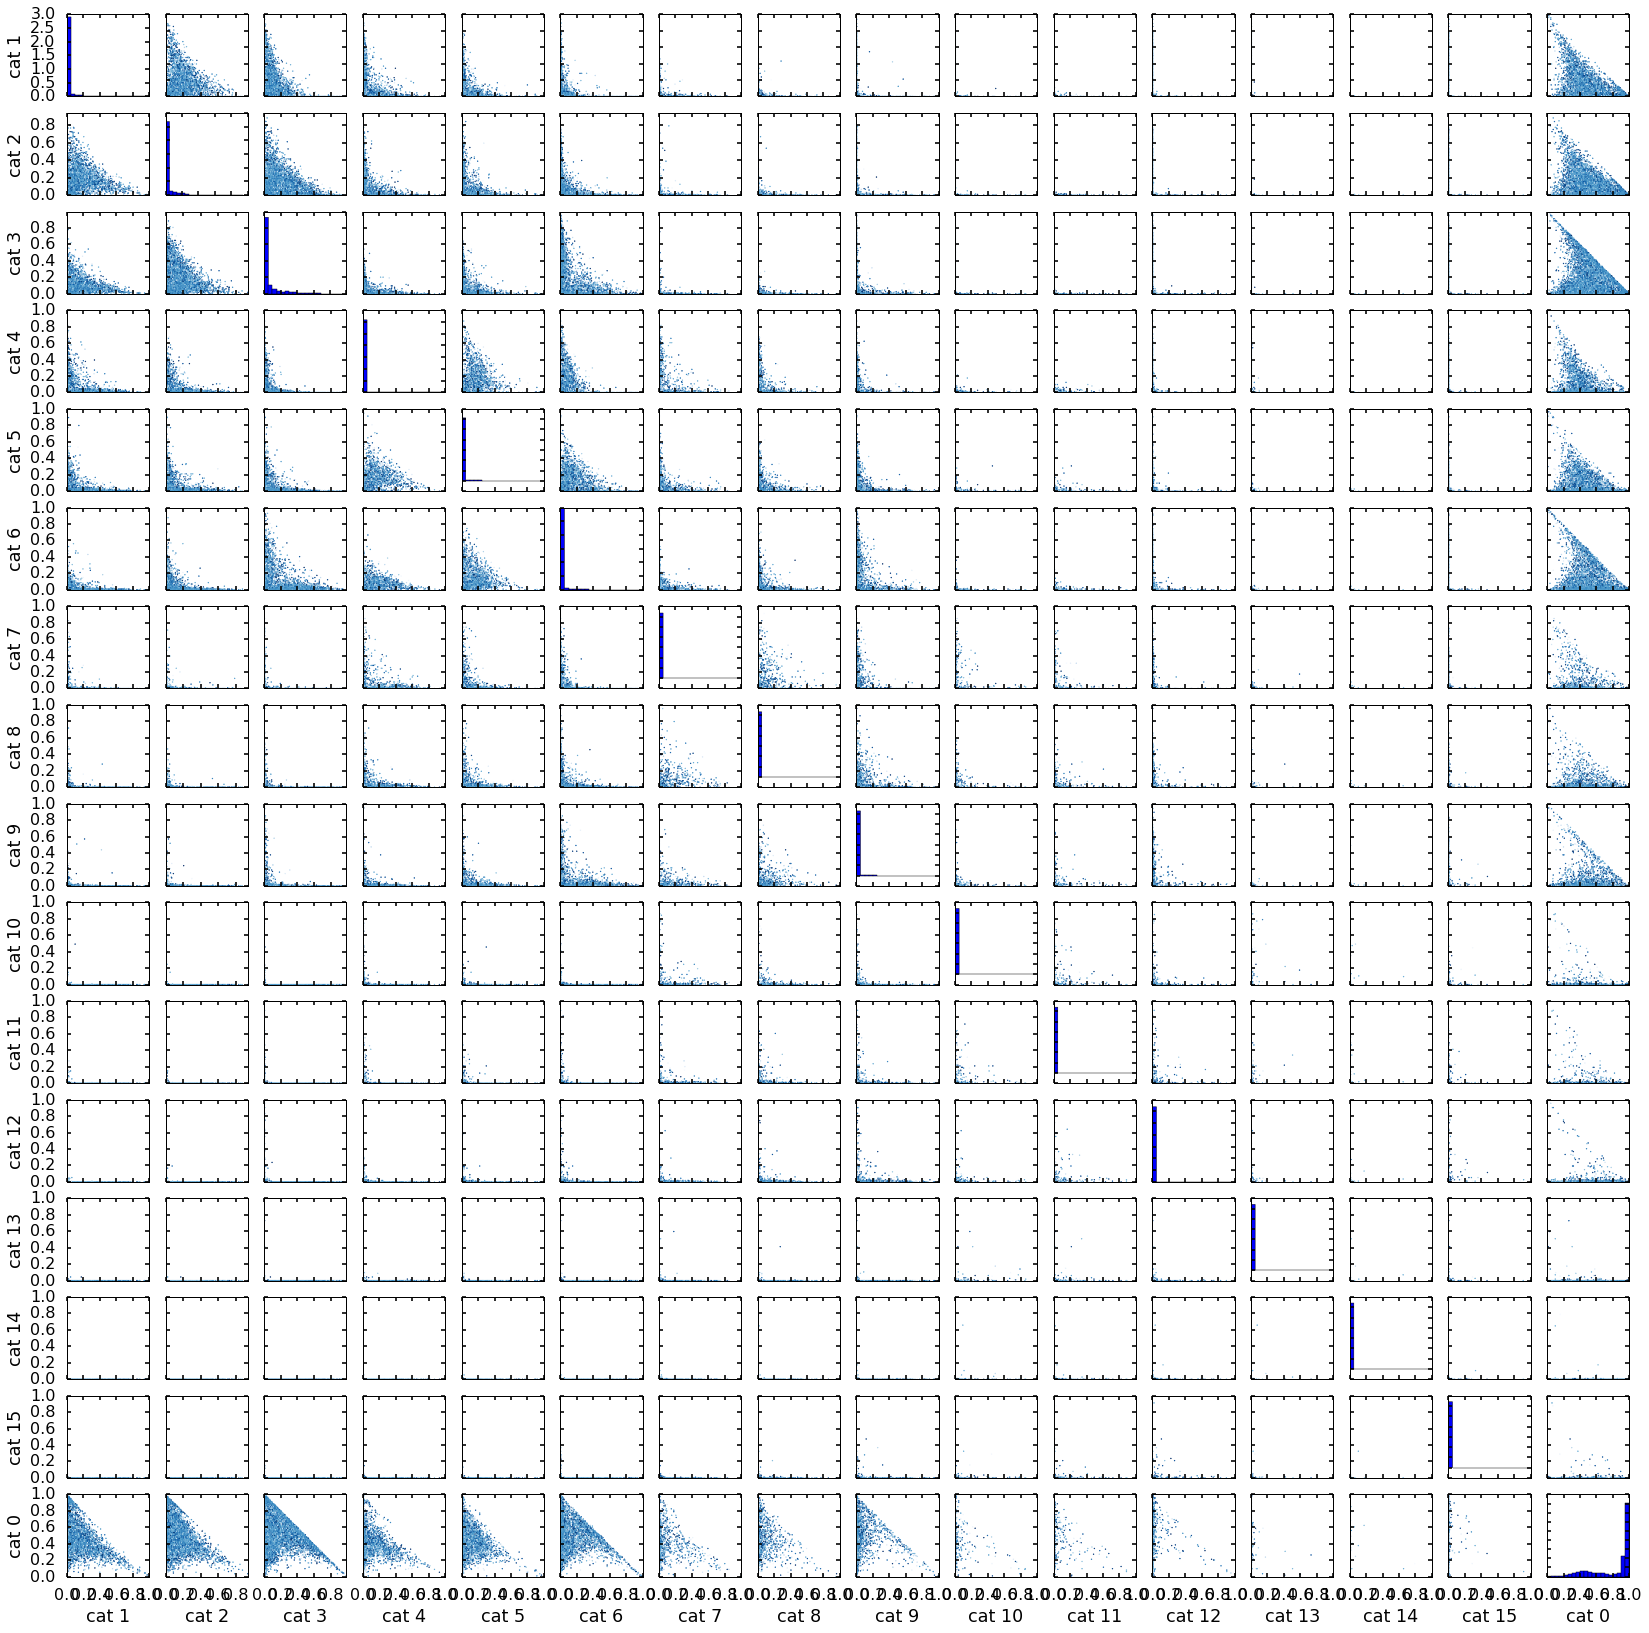

In [28]:
plotting.scatter_hist(df[:30000],allcols,figsize=(28,28),log=True)

In [ ]:
effFitter.clfs['recoNjets2p5'].inputs

In [29]:
tn.IO.save(effFitter)

In [33]:
effFitter.df.columns

Index([u'absweight', u'class', u'genJet2p5Pt0', u'genJet2p5Pt1',
       u'genJet2p5Pt2', u'genJet2p5Pt3', u'genJet2p5Rapidity0',
       u'genJet2p5Rapidity1', u'genJet2p5Rapidity2', u'genJet2p5Rapidity3',
       u'genNjets2p5', u'genPt', u'genRapidity', u'recoNjets2p5', u'recoPt',
       u'recoRapidity', u'weight', u'absGenRapidity', u'recoPtBin',
       u'recoPtCat', u'recoNjets2p5Bin', u'recoNjets2p5Cat', u'class_prob_0',
       u'class_prob_1', u'class_prob_2', u'class_prob_3', u'recoPt_prob_0',
       u'recoPt_prob_1', u'recoPt_prob_2', u'recoPt_prob_3', u'recoPt_prob_4',
       u'recoPt_prob_5', u'recoPt_prob_6', u'recoPt_prob_7', u'recoPt_prob_8',
       u'recoPt_prob_9', u'recoPt_prob_10', u'recoPt_prob_11',
       u'recoPt_prob_12', u'recoPt_prob_13', u'recoPt_prob_14',
       u'recoPt_prob_15', u'recoPt_prob_16', u'recoPt_prob_17',
       u'recoPt_prob_18', u'recoPt_prob_19', u'recoPt_prob_20',
       u'recoPt_prob_21', u'recoNjets2p5Cat_prob_0', u'recoNjets2p5Cat_prob_1',
   

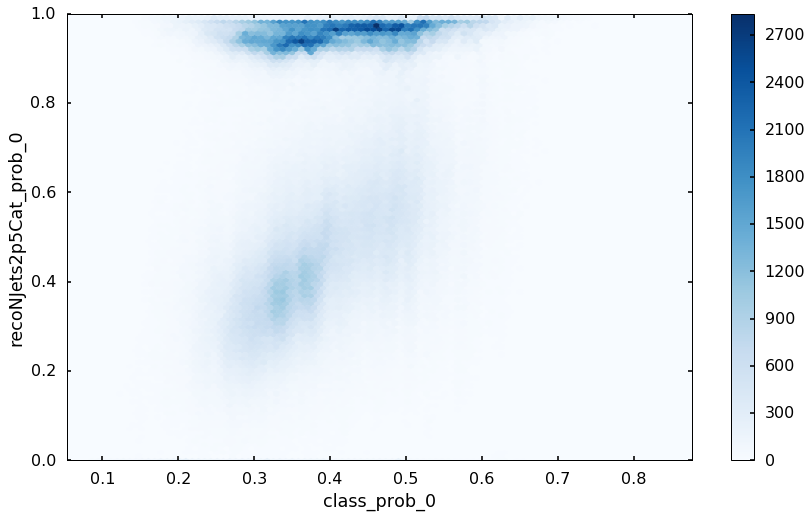

In [35]:
plt.figure(figsize=(14,8))
plt.hexbin(y=df['recoNjets2p5Cat_prob_0'], x=df['class_prob_0'],cmap=plt.cm.Blues)
plt.ylabel('recoNJets2p5Cat_prob_0')
plt.xlabel('class_prob_0')
plt.colorbar()